# Import data

$$
\langle T_{ij} \rangle = T_i\cdot \frac{m_i\cdot n_j}{(m_i+s_{ij})(m_i+n_j+s_{ij})}
$$
in which:
$$
T_i=\sum_{j\neq i}T_{ij}
$$
and $\langle T_{ij} \rangle$ means tha mean value of $T_{ij}$ within a period of time. 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

In [16]:
path = '/Users/paw_paw/Library/Mobile Documents/com~apple~CloudDocs/学习/PC5287_M.SC Coursework Thesis for Physics And Technology/data set/'

In [17]:
Prediction = pd.read_csv(path+'Prediction2019_gpr.csv')
Prediction.set_index('PA_name',inplace=True)

In [18]:
flux=pd.read_csv(path+'Total_flux_ij_2019.csv',index_col='PA_name')

# Evaluation

## Creat the graph

### Delete useless data 

In [19]:
# Replace infinities with nan so that they wont show in the graph

pre = Prediction.replace([np.inf, -np.inf], np.nan, inplace=False)
true = flux.replace([np.inf, -np.inf], np.nan, inplace=False)

In [20]:
# Define a function to delete the palces missing in the population density
def erase_pa(pa_list,df):
    for pa in pa_list:
        try:
            df=df.drop(columns=pa)[df.index!=pa]
        except KeyError:
            pass
    
    return df

# Also define a function to delete the diagram of the matrix 

def remove_diag(x):
    for i in range(0,pre.shape[0]):
        x.iat[i,i]=None
    return x


In [21]:
# delete the empty pa which are not included in the GPR 
empty_pa= ['CENTRAL WATER CATCHMENT',\
               'LIM CHU KANG',\
               'NORTH-EASTERN ISLANDS',\
               'SIMPANG',\
               'SOUTHERN ISLANDS',\
               'MARINA EAST',\
               'CHANGI BAY']
pre = erase_pa(empty_pa,pre)
true = erase_pa(empty_pa,true)

In [22]:
pre=remove_diag(pre)
true=remove_diag(true)

### Perform the heatmap

/Users/paw_paw/opt/anaconda3/envs/geo_env/lib/python3.10/site-packages/pandas/core/internals/blocks.py:351: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


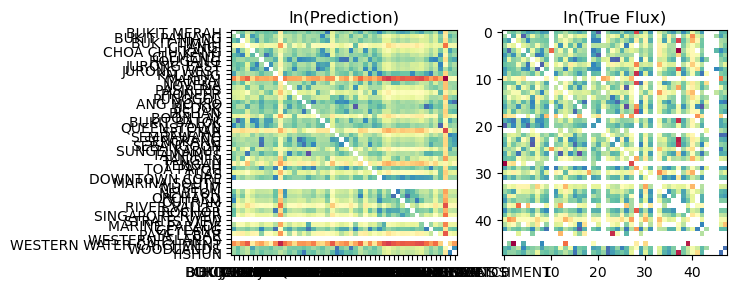

In [23]:
fig, ax = plt.subplots(1,2)

# fig.set_size_inches([12.8,9.6])


ax[0].imshow(np.log(pre), cmap='Spectral', interpolation='nearest')
ax[0].set(xticks=np.arange(pre.shape[0]), xticklabels=pre.index,\
          yticks=np.arange(pre.shape[1]), yticklabels=pre.columns ,\
          title='ln(Prediction)',autoscale_on=True)

# plt.setp(ax[0].get_xticklabels(), rotation=45, ha="right", 
# rotation_mode="anchor")


ax[1].imshow(np.log(true), cmap='Spectral', interpolation='nearest')
ax[1].set(title='ln(True Flux)')

fig.savefig(path+'/Prediction_2019.png')

plt.show()

### Perform the scatter plot

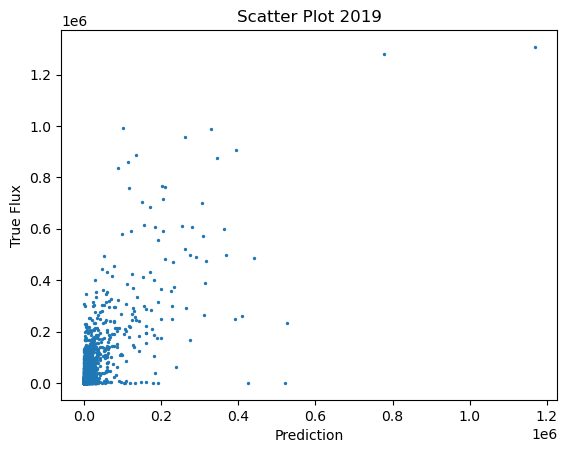

In [24]:
#Scatter plot 
plt.scatter(pre,true,s=2)
plt.xlabel('Prediction')
plt.ylabel('True Flux')
plt.title('Scatter Plot 2019')

# To show the plot
plt.show()

## Improvement and Metrics To Evaluate

### R2_score

In [25]:
from numpy import NaN,Inf

#### impute with geographically k-nearest neighbors

#### filling the missing data with KNN

#### Metrics
transform the data into an 1-D array and simply delete the missing data in both arrays 

In [26]:
from sklearn.metrics import r2_score,explained_variance_score,mean_absolute_percentage_error

In [27]:
X1=pre.to_numpy().flatten()
X2=true.to_numpy().flatten()

while sum(np.isnan(X1))>0:
    try:
        for i in range(0,X1.size):
            if np.isnan(X1[i]) or np.isnan(X2[i]):
                X1=np.delete(X1,[i])
                X2=np.delete(X2,[i])
    except IndexError:
        continue

print(r2_score(X2,X1),explained_variance_score(X2,X1),mean_absolute_percentage_error(X2,X1))

0.3773987729735139 0.4655624514470057 5.895414720553073e+18


In [28]:
# calculate the matrics according to land use
BUSINESS=pd.read_csv(path+'BUSINESS.csv').drop(columns='Unnamed: 0')
COMMERCIAL	=pd.read_csv(path+'COMMERCIAL.csv').drop(columns='Unnamed: 0')
RESIDENTIAL=pd.read_csv(path+'RESIDENTIAL.csv').drop(columns='Unnamed: 0')

In [29]:
(x1,x2)=(pre,true)
for i in true.index: 
    if i not in BUSINESS['PLN_AREA_N'].values:
        x1=erase_pa([i],x1)
        x2=erase_pa([i],x2)
        
x1=x1.to_numpy().flatten()
x2=x2.to_numpy().flatten()
while sum(np.isnan(x1))>0:
    try:
        for i in range(0,x1.size):
            if np.isnan(x1[i]) or np.isnan(x2[i]):
                x1=np.delete(x1,[i])
                x2=np.delete(x2,[i])
    except IndexError:
        continue

print(r'BUSINESS',r2_score(x2,x1),explained_variance_score(x2,x1),mean_absolute_percentage_error(x2,x1))

BUSINESS 0.4163037874097786 0.5191354652784701 8.425195936136237e+18


In [30]:
(x1,x2)=(pre,true)
for i in true.index: 
    if i not in COMMERCIAL['PLN_AREA_N'].values:
        x1=erase_pa([i],x1)
        x2=erase_pa([i],x2)
        
x1=x1.to_numpy().flatten()
x2=x2.to_numpy().flatten()
while sum(np.isnan(x1))>0:
    try:
        for i in range(0,x1.size):
            if np.isnan(x1[i]) or np.isnan(x2[i]):
                x1=np.delete(x1,[i])
                x2=np.delete(x2,[i])
    except IndexError:
        continue

print(r'COMMERCIAL',r2_score(x2,x1),explained_variance_score(x2,x1),mean_absolute_percentage_error(x2,x1))

COMMERCIAL 0.34157073913051006 0.5109354635323666 2.766663256197128e+18


In [31]:
(x1,x2)=(pre,true)
for i in true.index: 
    if i not in RESIDENTIAL['PLN_AREA_N'].values:
        x1=erase_pa([i],x1)
        x2=erase_pa([i],x2)
        
x1=x1.to_numpy().flatten()
x2=x2.to_numpy().flatten()
while sum(np.isnan(x1))>0:
    try:
        for i in range(0,x1.size):
            if np.isnan(x1[i]) or np.isnan(x2[i]):
                x1=np.delete(x1,[i])
                x2=np.delete(x2,[i])
    except IndexError:
        continue

print(r'RESIDENTIAL',r2_score(x2,x1),explained_variance_score(x2,x1),mean_absolute_percentage_error(x2,x1))

RESIDENTIAL 0.35311951662556695 0.4873787953915022 3.0469485640851896e+18


In [32]:
import matplotlib.lines as lines

[1.44781696]


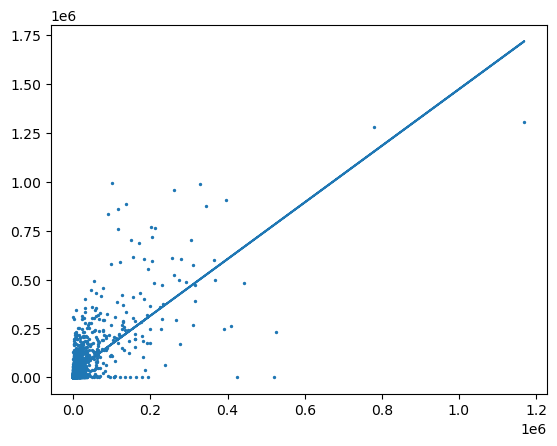

In [33]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X1.reshape(-1,1),X2)
coef=reg.coef_
print(coef)
plt.scatter(X1,X2,s=2)
plt.plot(X1,reg.predict(X1.reshape(-1,1)))

### Relative error

In [34]:
err = (pre-true).abs()

rlt_err = (err/pre).abs()

rlt_err_aprx=rlt_err.replace([-np.inf,np.inf], np.nan,inplace=False)

rlt_err_aprx=rlt_err_aprx.fillna(0)

In [35]:
for i in range(0,true.shape[0]):
    for j in range(0,true.shape[0]):
        if rlt_err_aprx.values[i,j]>=1:
            rlt_err_aprx.values[i,j]=1
        else:
            rlt_err_aprx.values[i,j]=0

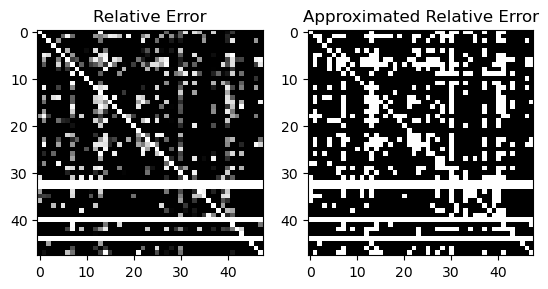

In [36]:
fig, ax = plt.subplots(1,2)

pre = rlt_err
true = rlt_err_aprx


ax[0].imshow(pre, cmap='Greys', interpolation='nearest',vmin=0, vmax=1)
ax[0].set(title='Relative Error',autoscale_on=True)

ax[1].imshow(true, cmap='Greys', interpolation='nearest',vmin=0, vmax=1)
ax[1].set(title='Approximated Relative Error',autoscale_on=True)

plt.show()

相对误差大于80%视为无效,小于视为有效。

In [37]:
sum(sum(1-rlt_err_aprx.values))/rlt_err.size

0.3003472222222222

In [38]:
import geopandas as gpd
import shapely
import fiona

fiona.supported_drivers['KML'] = 'rw'

pa = gpd.read_file(path+'/master-plan-2019-planning-area-boundary-no-sea/planning-boundary-area.kml', \
                            driver='KML')
pa = pa.to_crs(3414)

def extract_desc_pa(desc_pa):
    return desc_pa.split('PLN_AREA_N')[1].split('<td>')[1].split('<')[0]

pa['PLN_AREA_N'] = pa.Description.apply(extract_desc_pa)

pa['centroid'] = pa.centroid

pa_centroid=pa.set_index(['PLN_AREA_N'])['centroid'].to_dict()

def r_ij(pa_i,pa_j):
    return pa_centroid.get(pa_i).distance(pa_centroid.get(pa_j))

In [39]:
r = flux.copy().mask(flux!=np.nan)

In [40]:
for i in r.index:
    for j in r.columns:
        r.at[i,j]=r_ij(i,j)

In [41]:
r

,BUKIT MERAH,BUKIT PANJANG,BUKIT TIMAH,CENTRAL WATER CATCHMENT,CHANGI,CHOA CHU KANG,CLEMENTI,HOUGANG,JURONG EAST,JURONG WEST,...,SINGAPORE RIVER,STRAITS VIEW,CHANGI BAY,MARINE PARADE,GEYLANG,PAYA LEBAR,WESTERN ISLANDS,WESTERN WATER CATCHMENT,WOODLANDS,YISHUN
PA_name,,,,,,,,,,,,,,,,,,,,,
BUKIT MERAH,0.000000,11801.153055,7285.555760,11727.605889,21219.086601,15069.878839,8552.513484,12441.932351,10913.639880,15228.336785,...,2728.259723,5800.375314,26663.970694,9595.800021,9052.865975,13940.794275,12085.688405,19498.609475,19189.279821,15778.005629
BUKIT PANJANG,11801.153055,0.000000,4523.459054,3321.018256,25588.235593,3541.153151,5612.306333,13003.483794,7161.660539,8074.721069,...,11382.891056,16994.785211,32314.728877,18303.253061,13926.812556,15799.844748,16434.287300,9741.338977,8486.111357,8907.549437
BUKIT TIMAH,7285.555760,4523.459054,0.000000,5289.399414,23503.226876,7822.238515,3604.512914,11639.256997,6455.612039,9634.319694,...,7144.707832,12631.143946,29906.421553,14584.338004,11043.957271,14186.186644,13589.709392,12966.105831,12440.999877,10729.064832
CENTRAL WATER CATCHMENT,11727.605889,3321.018256,5289.399414,0.000000,22631.074216,6090.310227,7931.975597,9964.978992,10078.689893,11395.311798,...,10554.169342,16172.672171,29451.542056,16511.149567,11603.113070,12783.470977,18658.600711,12724.814637,7462.027830,5830.855805
CHANGI,21219.086601,25588.235593,23503.226876,22631.074216,0.000000,28721.187147,26933.095315,12672.382869,29848.896622,33015.701761,...,18736.425191,18079.710186,6963.328168,12612.107756,12680.341719,9854.516628,33281.851530,35305.476672,26431.880659,20016.590581
CHOA CHU KANG,15069.878839,3541.153151,7822.238515,6090.310227,28721.187147,0.000000,7665.759339,16054.709594,7949.201684,6764.542902,...,14861.216911,20432.304444,35531.702258,21842.495828,17378.827264,18873.452155,17795.965181,6695.187847,7637.796731,10525.326271
CLEMENTI,8552.513484,5612.306333,3604.512914,7931.975597,26933.095315,7665.759339,0.000000,15237.912494,2915.876061,6759.275772,...,9455.620533,14335.079601,33205.065530,17242.020949,14335.773634,17754.262382,10850.901590,10976.676667,14089.693860,13724.053165
HOUGANG,12441.932351,13003.483794,11639.256997,9964.978992,12672.382869,16054.709594,15237.912494,0.000000,18087.006227,20720.697846,...,9764.025224,13074.963742,19535.809090,10063.800977,4726.302388,2819.030407,23786.112430,22669.752026,14453.758890,8165.684903
JURONG EAST,10913.639880,7161.660539,6455.612039,10078.689893,29848.896622,7949.201684,2915.876061,18087.006227,0.000000,4450.050813,...,12163.252093,16703.135832,36105.108163,19975.136500,17243.648729,20639.451542,9857.936895,9272.310087,15231.572635,15900.703937
